## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import plotnine
from plotnine import *
import os
import glob
import pickle

from datetime import datetime

## Combine files into data frame

In [2]:
# Import data
dir_path = 'D:\OneDrive - Chalmers\Git\EEN210_Applied_Digital_Health_temp\data\data_labeled'
files = glob.glob(os.path.join(dir_path , '*_labeled.csv'))

dataset_all = []

# Columns to read from each file
columns_to_read = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'gyroscope_x', 'gyroscope_y', 'gyroscope_z', 'timestamp', 'label']

# Loop append each file
for file_path in files:
    df = pd.read_csv(file_path, index_col=None, header=0, usecols=columns_to_read)
    df['filename'] = os.path.splitext(os.path.basename(file_path))[0]
    dataset_all.append(df)
    print(os.path.splitext(os.path.basename(file_path))[0])

# Concatenate all data
dataset_all = pd.concat(dataset_all, axis=0, ignore_index=True)

fall_back_data_20240129_163134_labeled
fall_back_mew_data_20240129_165424_labeled
fall_front_data_20240129_163754_labeled
fall_front_mew_data_20240129_170336_labeled
fall_sideLeft_data_20240129_164741_labeled
fall_sideRight_data_20240129_164251_labeled
stairs_down_data_20240124_150347_labeled
stairs_down_data_20240124_152206_labeled
stairs_down_data_20240124_152408_labeled
stairs_down_data_20240124_152621_labeled
stairs_up_data_20240124_152108_labeled
stairs_up_data_20240124_152306_labeled
stairs_up_data_20240124_152516_labeled
standing_data_20240124_143101_labeled
standing_data_20240124_143514_labeled
standing_data_20240124_143747_labeled
walking_data_20240124_142045_labeled
walking_data_20240124_142333_labeled
walking_data_20240124_142757_labeled


## Investigate missing value

In [3]:
dataset_all['label'].value_counts().sort_values(ascending = True)

label
fall_right      128
fall_left       131
fall_front      395
fall_back       485
stair_up       1515
stair_down     2073
get_up         2081
laying         4861
walking        7612
standing      11895
Name: count, dtype: int64

## Remove baseline and extract features

In [4]:
import scipy
from scipy.stats import skew 
from scipy.stats import kurtosis 
from scipy import signal

def get_psd(df, fs, bin_width=1.0, window="hann"):
    
    f, psd = signal.welch(df.values, fs=fs, nperseg= int(fs / bin_width), window=window, axis=0)

    df_psd = pd.DataFrame(psd, columns=df.columns)
    df_psd["Frequency_Hz"] = f
    df_psd = df_psd.set_index("Frequency_Hz")
    return df_psd

# power spectrum of signal
def get_fft(df, fs):
    npnts = len(df)
    df_fft = np.abs(scipy.fftpack.fft(df.values)/npnts)**2
    f = np.linspace(0,fs/2,int(np.floor(npnts/2)+1))
    return df_fft, f

In [5]:
def apply_LR_acc_x_median(feat):
    with open('./model/LR_acc_x_median/LR_scaler.pkl','rb') as sc_file:
        LR_sc = pickle.load(sc_file)

    with open('./model/LR_acc_x_median/LR_classifier_model.pkl', 'rb') as model_file:  
        LR_classifier = pickle.load(model_file)

    feat2 = np.array(feat['acceleration_x_median'].fillna(0))
    feat2 = np.lib.stride_tricks.sliding_window_view(feat2, 11)
    feat2 =  LR_sc.transform(feat2)
    x_prob = LR_classifier.predict_proba(feat2)[:,1]

    x_prob_final = np.ones(feat.shape[0])*np.nan
    x_prob_final[5:-5] = x_prob

    return x_prob_final


def apply_LR_acc_mag_mean(feat):
    with open('./model/LR_acc_magnitude_mean/LR_scaler.pkl','rb') as sc_file:
        LR_sc = pickle.load(sc_file)

    with open('./model/LR_acc_magnitude_mean/LR_classifier_model.pkl', 'rb') as model_file:  
        LR_classifier = pickle.load(model_file)

    feat2 = np.array(feat['acc_magnitude_mean'].fillna(0))
    feat2 = np.lib.stride_tricks.sliding_window_view(feat2, 11)
    feat2 =  LR_sc.transform(feat2)
    x_prob = LR_classifier.predict_proba(feat2)[:,1]

    x_prob_final = np.ones(feat.shape[0])*np.nan
    x_prob_final[5:-5] = x_prob

    return x_prob_final


def apply_LR_acc_mag_std(feat):
    with open('./model/LR_acc_magnitude_std/LR_scaler.pkl','rb') as sc_file:
        LR_sc = pickle.load(sc_file)

    with open('./model/LR_acc_magnitude_std/LR_classifier_model.pkl', 'rb') as model_file:  
        LR_classifier = pickle.load(model_file)

    feat2 = np.array(feat['acc_magnitude_std'].fillna(0))
    feat2 = np.lib.stride_tricks.sliding_window_view(feat2, 11)
    feat2 =  LR_sc.transform(feat2)
    x_prob = LR_classifier.predict_proba(feat2)[:,1]

    x_prob_final = np.ones(feat.shape[0])*np.nan
    x_prob_final[5:-5] = x_prob

    return x_prob_final


def apply_LR_acceleration_x(feat):
    with open('./model/LR_acceleration_x/LR_scaler.pkl','rb') as sc_file:
        LR_sc = pickle.load(sc_file)

    with open('./model/LR_acceleration_x/LR_classifier_model.pkl', 'rb') as model_file:  
        LR_classifier = pickle.load(model_file)

    feat2 = np.array(feat['acceleration_x'].fillna(0))
    feat2 = np.lib.stride_tricks.sliding_window_view(feat2, 21)
    feat2 =  LR_sc.transform(feat2)
    x_prob = LR_classifier.predict_proba(feat2)[:,1]

    x_prob_final = np.ones(feat.shape[0])*np.nan
    x_prob_final[10:-10] = x_prob

    return x_prob_final

def apply_LR_acc_magnitude(feat):
    with open('./model/LR_acc_magnitude/LR_scaler.pkl','rb') as sc_file:
        LR_sc = pickle.load(sc_file)

    with open('./model/LR_acc_magnitude/LR_classifier_model.pkl', 'rb') as model_file:  
        LR_classifier = pickle.load(model_file)

    feat2 = np.array(feat['acc_magnitude'].fillna(0))
    feat2 = np.lib.stride_tricks.sliding_window_view(feat2, 11)
    feat2 =  LR_sc.transform(feat2)
    x_prob = LR_classifier.predict_proba(feat2)[:,1]

    x_prob_final = np.ones(feat.shape[0])*np.nan
    x_prob_final[5:-5] = x_prob

    return x_prob_final

In [6]:
def rm_baseline(x, nwin):    
    N = len(x)
    idx = int((nwin-1)/2)
    x_norm = np.zeros(N)*np.nan
    
    # Remove baseline with mean
    for i in np.arange(N-idx):
        x_win = x[i:(i+nwin)]
        x_mean = np.mean(x_win)
        x_norm[i+idx] = x[i+idx]-x_mean

    return x_norm

def calFeat(df, nwin, nwin_baseline):

    # Smoothing acc signal
    feat_1 = df.rolling(window=nwin_baseline, center = True)['acceleration_x', 'acceleration_y', 'acceleration_z'].agg(["median"])
    feat_1.columns = [f"{col[0]}_{col[1]}" for col in feat_1.columns]

    # Remove baseline signal    
    dataset_rm = df.apply(lambda x: rm_baseline(x.values, 11))

    # Calculate magnitude using Euclidean norm
    dataset_rm['acc_magnitude'] = np.sqrt(dataset_rm['acceleration_x']**2 +
                                    dataset_rm['acceleration_y']**2 +
                                    dataset_rm['acceleration_z']**2)

    dataset_rm['gyr_magnitude'] = np.sqrt(dataset_rm['gyroscope_x']**2 +
                                    dataset_rm['gyroscope_y']**2 +
                                    dataset_rm['gyroscope_z']**2)
    
    # Calculate time domain features
    feat_2 = dataset_rm.rolling(window=nwin, center = True).agg(["sum", "mean", "std", "min", "max"])
    feat_2.columns = [f"{col[0]}_{col[1]}" for col in feat_2.columns]

    dataset_rm.columns = ['acceleration_x_rm', 'acceleration_y_rm', 'acceleration_z_rm', 'gyroscope_x_rm','gyroscope_y_rm', 'gyroscope_z_rm','acc_magnitude','gyr_magnitude']
    
    # Calculate time domain features   
    # feat_3 = abs(dataset_rm).rolling(window=nwin, center = True).agg(["mean", "min", "max"])
    # feat_3.columns = [f"{col[0]}_abs_{col[1]}" for col in feat_3.columns]

    return pd.concat([df, feat_1, dataset_rm, feat_2], axis=1)

nwin_feat = 11
nwin_rm_baseline = 21 # = 1 sec (samplize rate = 20 Hz)
cols = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'gyroscope_x','gyroscope_y', 'gyroscope_z']

dataset_feat = pd.DataFrame()  # Initialize as an empty DataFrame
for fn in dataset_all['filename'].unique():

    # Get individual file
    dataset = dataset_all.loc[lambda df: df['filename']==fn, :]
        
    # Feature extraction
    feat = calFeat(dataset[cols], nwin_feat, nwin_rm_baseline)

    # feat.loc[:,'acceleration_x_median_LR'] = apply_LR_acc_x_median(feat)    
    # feat.loc[:,'acceleration_mag_std_LR'] = apply_LR_acc_mag_std(feat)
    # feat.loc[:,'acceleration_mag_mean_LR'] = apply_LR_acc_mag_mean(feat)
    feat.loc[:,'acceleration_x_LR'] = apply_LR_acceleration_x(dataset[cols])
    feat.loc[:,'acc_magnitude_LR'] = apply_LR_acc_magnitude(feat)
    feat.loc[:,'label'] = dataset.loc[:,'label']
    feat.loc[:,'filename'] = dataset.loc[:,'filename']
    dataset_feat = pd.concat([dataset_feat, feat], ignore_index=True)
    
# Change timestamp to datetime if needed
# dataset_feat.loc[:, 'timestamp'] = pd.to_datetime(dataset_feat['timestamp'], format="%Y-%m-%d %H:%M:%S")



In [7]:
dataset_feat.head(20)

,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,acceleration_x_median,acceleration_y_median,acceleration_z_median,acceleration_x_rm,...,acc_magnitude_max,gyr_magnitude_sum,gyr_magnitude_mean,gyr_magnitude_std,gyr_magnitude_min,gyr_magnitude_max,acceleration_x_LR,acc_magnitude_LR,label,filename
0,4292,-570,847,23,-60,-14,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,standing,fall_back_data_20240129_163134_labeled
1,4132,-223,886,-14,-14,53,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,standing,fall_back_data_20240129_163134_labeled
2,4254,-361,1013,18,-78,25,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,standing,fall_back_data_20240129_163134_labeled
3,4321,-270,979,-38,-65,31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,standing,fall_back_data_20240129_163134_labeled
4,4228,-371,1083,-68,-70,18,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,standing,fall_back_data_20240129_163134_labeled
5,4107,-303,859,-19,42,-1,NaN,NaN,NaN,-118.363636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011817,standing,fall_back_data_20240129_163134_labeled
6,4244,-329,988,-30,-3,6,NaN,NaN,NaN,36.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012125,standing,fall_back_data_20240129_163134_labeled
7,4184,-278,961,6,-6,-2,NaN,NaN,NaN,-40.363636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012207,standing,fall_back_data_20240129_163134_labeled
8,4284,-297,944,-56,-18,5,NaN,NaN,NaN,66.090909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012143,standing,fall_back_data_20240129_163134_labeled
9,4135,-201,1011,-32,-29,-16,NaN,NaN,NaN,-86.363636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012474,standing,fall_back_data_20240129_163134_labeled


In [8]:
# dataset_feat.to_csv("combined_df_feat.csv", index = False)

## Mapping classes

In [9]:
def map_label_to_new_category(label):
    if 'fall' in str(label):
        return 'falling'
    elif 'walking' in str(label):
        return 'walking'
    elif 'standing' in str(label):
        return 'standing'    
    elif 'laying' in str(label):
        return 'laying'    
    else:
        return 'other'

# Apply the function to create a new label column
dataset_feat['simple_label'] = dataset_feat['label'].apply(map_label_to_new_category)

dataset_feat.head(10)

,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,acceleration_x_median,acceleration_y_median,acceleration_z_median,acceleration_x_rm,...,gyr_magnitude_sum,gyr_magnitude_mean,gyr_magnitude_std,gyr_magnitude_min,gyr_magnitude_max,acceleration_x_LR,acc_magnitude_LR,label,filename,simple_label
0,4292,-570,847,23,-60,-14,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,standing,fall_back_data_20240129_163134_labeled,standing
1,4132,-223,886,-14,-14,53,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,standing,fall_back_data_20240129_163134_labeled,standing
2,4254,-361,1013,18,-78,25,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,standing,fall_back_data_20240129_163134_labeled,standing
3,4321,-270,979,-38,-65,31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,standing,fall_back_data_20240129_163134_labeled,standing
4,4228,-371,1083,-68,-70,18,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,standing,fall_back_data_20240129_163134_labeled,standing
5,4107,-303,859,-19,42,-1,NaN,NaN,NaN,-118.363636,...,NaN,NaN,NaN,NaN,NaN,NaN,0.011817,standing,fall_back_data_20240129_163134_labeled,standing
6,4244,-329,988,-30,-3,6,NaN,NaN,NaN,36.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.012125,standing,fall_back_data_20240129_163134_labeled,standing
7,4184,-278,961,6,-6,-2,NaN,NaN,NaN,-40.363636,...,NaN,NaN,NaN,NaN,NaN,NaN,0.012207,standing,fall_back_data_20240129_163134_labeled,standing
8,4284,-297,944,-56,-18,5,NaN,NaN,NaN,66.090909,...,NaN,NaN,NaN,NaN,NaN,NaN,0.012143,standing,fall_back_data_20240129_163134_labeled,standing
9,4135,-201,1011,-32,-29,-16,NaN,NaN,NaN,-86.363636,...,NaN,NaN,NaN,NaN,NaN,NaN,0.012474,standing,fall_back_data_20240129_163134_labeled,standing


In [10]:
# # Investigate features 
# dataset_feat_long = pd.melt(dataset_feat, 
#                             id_vars=['simple_label','label'],
#                             value_vars=["acceleration_x_median","acc_magnitude_mean","acc_magnitude_std", "gyr_magnitude_mean","gyr_magnitude_std"], 
#                             var_name='feat', 
#                             value_name='val')

# dataset_feat_long = dataset_feat_long.dropna()

# ggplot(dataset_feat_long, aes(x='feat', y='val', fill='simple_label'))+geom_boxplot()+theme(axis_text_x  = element_text(angle = 90, hjust = 1))

## Model Training

### Prepare data for training

In [11]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE 
from sklearn.linear_model import LogisticRegression

In [12]:
data = dataset_feat.dropna()
data = data[data["simple_label"].isin(["falling", "walking", "standing","laying"])]
X = data.drop(['label','simple_label','filename'], axis=1)
y = data['simple_label']
cols_feat = X.columns
cols_feat

Index(['acceleration_x', 'acceleration_y', 'acceleration_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z', 'acceleration_x_median',
       'acceleration_y_median', 'acceleration_z_median', 'acceleration_x_rm',
       'acceleration_y_rm', 'acceleration_z_rm', 'gyroscope_x_rm',
       'gyroscope_y_rm', 'gyroscope_z_rm', 'acc_magnitude', 'gyr_magnitude',
       'acceleration_x_sum', 'acceleration_x_mean', 'acceleration_x_std',
       'acceleration_x_min', 'acceleration_x_max', 'acceleration_y_sum',
       'acceleration_y_mean', 'acceleration_y_std', 'acceleration_y_min',
       'acceleration_y_max', 'acceleration_z_sum', 'acceleration_z_mean',
       'acceleration_z_std', 'acceleration_z_min', 'acceleration_z_max',
       'gyroscope_x_sum', 'gyroscope_x_mean', 'gyroscope_x_std',
       'gyroscope_x_min', 'gyroscope_x_max', 'gyroscope_y_sum',
       'gyroscope_y_mean', 'gyroscope_y_std', 'gyroscope_y_min',
       'gyroscope_y_max', 'gyroscope_z_sum', 'gyroscope_z_mean',
       'gyros

In [13]:
data['simple_label'].value_counts().sort_values(ascending = True)

simple_label
falling      1139
laying       4851
walking      7522
standing    11755
Name: count, dtype: int64

### Feature selection

In [22]:
import operator
from sklearn.model_selection import  StratifiedKFold

# Create a random forest classifier
rfc = RandomForestClassifier(n_estimators=10, class_weight='balanced', criterion='gini', random_state=42) # Use gini criterion to define feature importance
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform cross-validation and calculate feature importance
list_feature_importance = []  

for train_index, test_index in k_fold.split(X, y):
    X_train = X.iloc[train_index,:]
    y_train = y.iloc[train_index]

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)

    # Train the classifier
    rfc.fit(X_train, y_train)
    importances = rfc.feature_importances_

    list_feature_importance.append(importances)

# Print the name and gini importance of each feature
# selected_feature = []
# for feature in zip(cols_feat, rfc.feature_importances_):     
#     # print(feature)
#     if feature[1] > 0.03:
#         selected_feature.append(feature[0])

# Calculate average feature importance
avg_importance = np.mean(list_feature_importance, axis=0)

zipped = list(zip(X.columns, avg_importance))

sorted_zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
sorted_list1, sorted_list2 = zip(*sorted_zipped)


# create DataFrame using data
df_imp = pd.DataFrame(sorted_zipped, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()
df_imp.head(30)


,FEATURE,IMPORTANCE,CUMSUM
0,acceleration_x_median,0.159733,0.159733
1,acceleration_x_LR,0.102522,0.262255
2,acceleration_x_std,0.087931,0.350186
3,acc_magnitude_mean,0.086659,0.436845
4,acceleration_x_max,0.062997,0.499842
5,acceleration_x,0.056515,0.556357
6,acceleration_z_median,0.043477,0.599833
7,acceleration_z_min,0.034212,0.634045
8,acc_magnitude_max,0.027360,0.661405
9,acceleration_z,0.026909,0.688314


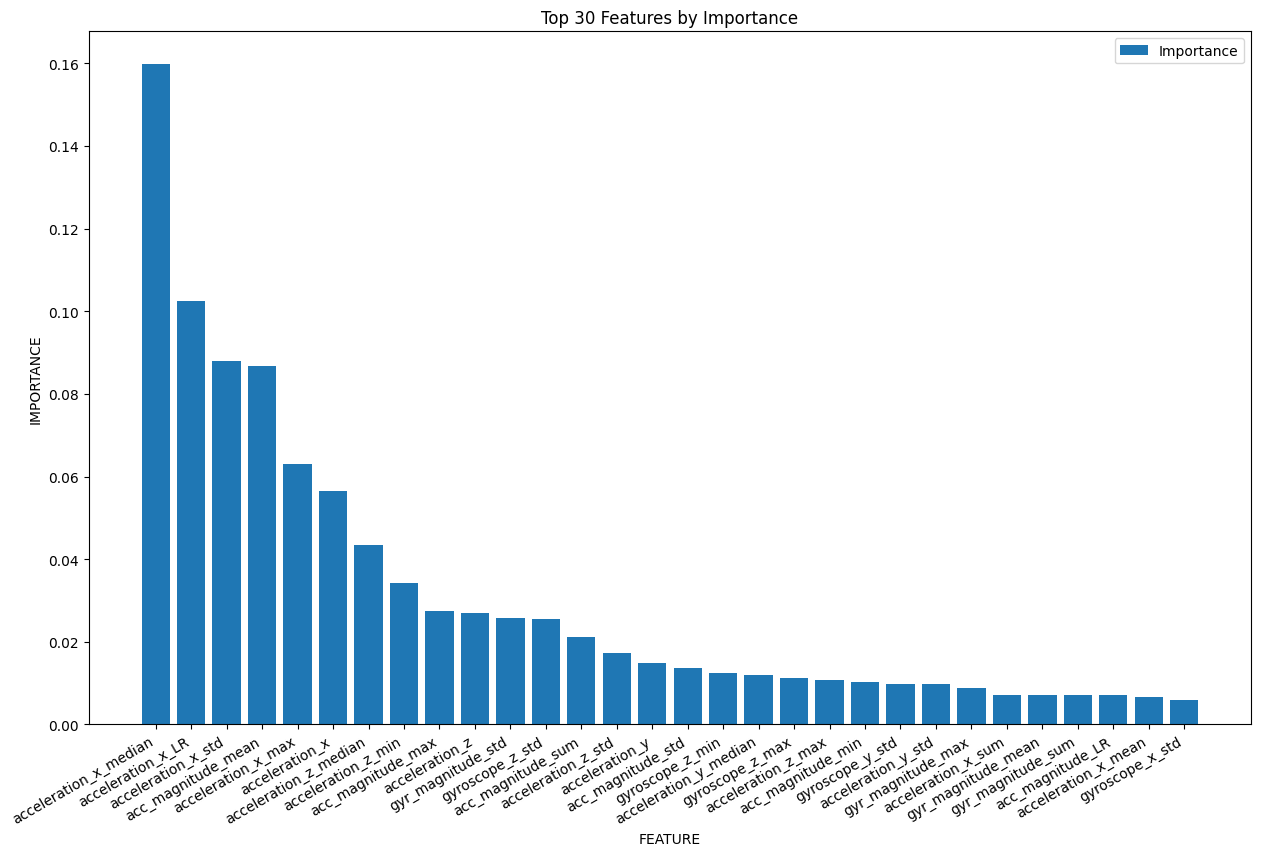

In [25]:


# Sort the DataFrame by 'IMPORTANT' in descending order
df_imp_sorted = df_imp.sort_values(by='IMPORTANCE', ascending=False)

# Calculate the cumulative sum of 'IMPORTANT'
df_imp_sorted['CUMULATIVE'] = df_imp_sorted['IMPORTANCE'].cumsum()

# Plot the bar chart for 'IMPORTANCE'
plt.figure(figsize=(15, 9))

plt.bar(df_imp_sorted['FEATURE'][:30], df_imp_sorted['IMPORTANCE'][:30], label='Importance')
plt.xlabel('FEATURE')
plt.ylabel('IMPORTANCE')

plt.xticks(rotation=30, ha='right')
plt.legend()
plt.title('Top 30 Features by Importance')
plt.show()

In [26]:
to_drop = []
selected_feature = list(sorted_list1)[0:df_imp[df_imp['CUMSUM']>0.9].index[0]]
selected_feature

['acceleration_x_median',
 'acceleration_x_LR',
 'acceleration_x_std',
 'acc_magnitude_mean',
 'acceleration_x_max',
 'acceleration_x',
 'acceleration_z_median',
 'acceleration_z_min',
 'acc_magnitude_max',
 'acceleration_z',
 'gyr_magnitude_std',
 'gyroscope_z_std',
 'acc_magnitude_sum',
 'acceleration_z_std',
 'acceleration_y',
 'acc_magnitude_std',
 'gyroscope_z_min',
 'acceleration_y_median',
 'gyroscope_z_max',
 'acceleration_z_max',
 'acc_magnitude_min',
 'gyroscope_y_std',
 'acceleration_y_std',
 'gyr_magnitude_max',
 'acceleration_x_sum']

### Check correlation - drop high correlation feature

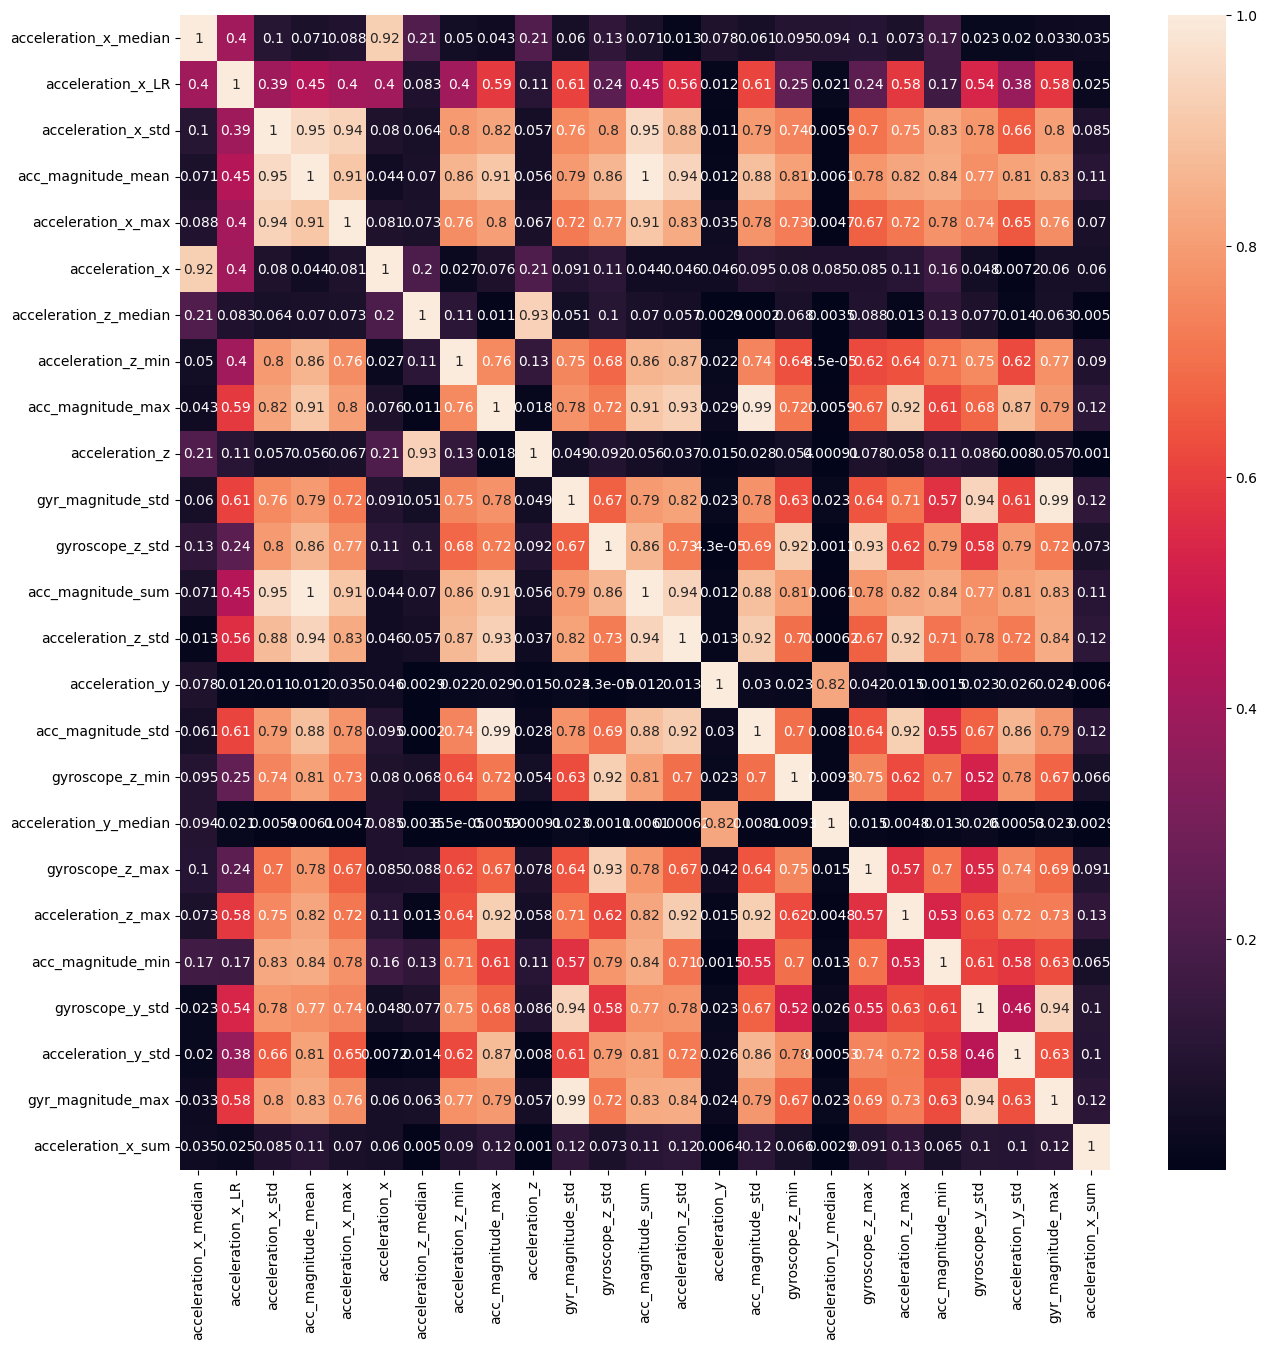

In [27]:
import seaborn as sns
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
hm = X[selected_feature]
# hm = X_train[list(sorted_list1)]

plt.figure(figsize=(15,15))
sns.heatmap(hm.corr().abs(), annot=True)
plt.show()

In [28]:
# Create correlation matrix
corr_matrix = hm.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features 
# hm_select = hm.drop(to_drop, axis=1, inplace=True)

to_drop

['acc_magnitude_mean',
 'acceleration_x_max',
 'acceleration_x',
 'acc_magnitude_max',
 'acceleration_z',
 'acc_magnitude_sum',
 'acceleration_z_std',
 'acc_magnitude_std',
 'gyroscope_z_min',
 'gyroscope_z_max',
 'acceleration_z_max',
 'gyroscope_y_std',
 'gyr_magnitude_max']

### Train-Test split

In [29]:
# Select only important features
X_selected = X[selected_feature].drop(to_drop, axis=1)
feature_select = X_selected.columns
feature_select


Index(['acceleration_x_median', 'acceleration_x_LR', 'acceleration_x_std',
       'acceleration_z_median', 'acceleration_z_min', 'gyr_magnitude_std',
       'gyroscope_z_std', 'acceleration_y', 'acceleration_y_median',
       'acc_magnitude_min', 'acceleration_y_std', 'acceleration_x_sum'],
      dtype='object')

In [30]:
def calculate_mean_metrics(list_classification_reports):
    # Initialize dictionaries to store the sum of metrics for each label
    falling_sum = {'precision': [], 'recall': [], 'f1-score': [], 'support': []}
    laying_sum = {'precision': [], 'recall': [], 'f1-score': [], 'support': []}
    standing_sum = {'precision': [], 'recall': [], 'f1-score': [], 'support': []}
    walking_sum = {'precision': [], 'recall': [], 'f1-score': [], 'support': []}
    accuracy_sum = []

    # Iterate over each dictionary and update the sums
    for entry in list_classification_reports:
        for label in ['precision', 'recall', 'f1-score', 'support']:
            falling_sum[label].append(entry['falling'][label])
            laying_sum[label].append(entry['laying'][label])
            standing_sum[label].append(entry['standing'][label])
            walking_sum[label].append(entry['walking'][label])

        accuracy_sum.append(entry['accuracy'])

    # Calculate means
    falling_mean = {label: round(np.mean(falling_sum[label]),2) for label in falling_sum}
    laying_mean = {label: round(np.mean(laying_sum[label]),2) for label in laying_sum}
    standing_mean = {label: round(np.mean(standing_sum[label]),2) for label in standing_sum}
    walking_mean = {label: round(np.mean(walking_sum[label]),2) for label in walking_sum}
    accuracy_mean = round(np.mean(accuracy_sum),3)

    # Combine mean metrics into a single dictionary
    mean_metrics = {
        'falling': falling_mean,
        'laying': laying_mean,
        'standing': standing_mean,
        'walking': walking_mean,
        'Accuracy': accuracy_mean
    }

    print("Falling:", falling_mean)
    print("Laying:", laying_mean)
    print("Standing:", standing_mean)
    print("Walking:", walking_mean)
    print("Accuracy:", accuracy_mean)

    return mean_metrics



### Model Training (cv) - Random forest

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest classifier
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [5, 10, 15, 20],  
    'max_depth': [5, 10, 15, 20],
}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_selected, y)

# Get the best parameters and the corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'max_depth': 10, 'n_estimators': 20}
Best Score: 0.9665574902080681


In [32]:
from sklearn.feature_selection import RFE

# Initialize the Random Forest classifier
classifier = RandomForestClassifier(n_estimators=20, max_depth=10, class_weight='balanced', random_state=42)
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Train data with 10-folds cross validation
list_classification_reports = []
for train_index, test_index in k_fold.split(X_selected, y):
    X_train, X_test = X_selected.iloc[train_index,:], X_selected.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)

    # Train the classifier
    classifier.fit(X_train, y_train)

    # Make predictions on the testing set
    y_pred = classifier.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    list_classification_reports.append(report)

# Calculate mean classification report
_ = calculate_mean_metrics(list_classification_reports)


# # Select features using Recursive Feature Elimination
# rfe = RFE(estimator=classifier, n_features_to_select=7)
# rfe = rfe.fit(X_train, y_train)

# # Print selected features
# print("Selected features:", feature_select[rfe.support_])

# Transform the data to include only the selected features
# X_train = rfe.transform(X_train)
# X_test = rfe.transform(X_test)


Falling: {'precision': 0.92, 'recall': 0.9, 'f1-score': 0.91, 'support': 113.9}
Laying: {'precision': 0.99, 'recall': 0.99, 'f1-score': 0.99, 'support': 485.1}
Standing: {'precision': 0.99, 'recall': 0.99, 'f1-score': 0.99, 'support': 1175.5}
Walking: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 752.2}
Accuracy: 0.99


### Model training (final model use all dataset) 

In [33]:
# Train-Test split
# X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
X_train = X_selected
y_train = y

# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# Train Random Forest classifier on selected features
classifier.fit(X_train, y_train)

# Make predictions on the testing set
# y_pred = classifier.predict(X_test)

#report
print('Train set')
classification_report_str = classification_report(y_train, classifier.predict(X_train))
print(classification_report_str)

# print('Test set')
# classification_report_str = classification_report(y_test, y_pred)
# print(classification_report_str)

# # performance
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy}')

Train set
              precision    recall  f1-score   support

     falling       0.94      0.99      0.96      1139
      laying       1.00      1.00      1.00      4851
    standing       1.00      0.99      1.00     11755
     walking       1.00      1.00      1.00      7522

    accuracy                           1.00     25267
   macro avg       0.98      0.99      0.99     25267
weighted avg       1.00      1.00      1.00     25267



### Plot random forest

In [ ]:
from sklearn import tree
plt.figure(figsize=(20,20))
_ = tree.plot_tree(classifier.estimators_[0], feature_names=X_selected.columns, filled=True)
plt.show()

In [34]:
classifier.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### Save model - RF

In [35]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "./model/RandomForest_3/RF_classifier_model.pkl"  
scaler_pkl_file = "./model/RandomForest_3/scaler.pkl"  

with open(model_pkl_file, 'wb') as model_file:  
    pickle.dump(classifier, model_file)

with open(scaler_pkl_file,'wb') as sc_file:
    pickle.dump(sc, sc_file)

### Model Training - Linear regresion (single feature)

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view

data = dataset_feat.dropna()
data = data[data["simple_label"].isin(["falling", "walking", "standing","laying"])]

v=[]
w=[]
nwin = 11
nwin_half = int(np.floor(nwin/2))
for f in data.filename.unique():
    data_ind = data.loc[lambda df: df['filename']==f, :]
    X = data_ind.drop(['label','simple_label','filename'], axis=1)
    y = data_ind['simple_label']

    X_feat = X['acc_magnitude'] #acc_magnitude_mean, acceleration_x_median
    # print(X_acc_x_median.shape)

    v_temp = sliding_window_view(X_feat, nwin)
    # print(v.shape)

    w_temp = y[nwin_half:-nwin_half]
    w_temp = (w_temp=='falling')*1

    v.append(v_temp)
    w.append(w_temp)

v = np.concatenate(v, axis=0)
w = np.concatenate(w, axis=0)
print(v.shape)

In [ ]:
# Logistic regression
X_train, X_test, y_train, y_test = train_test_split(v, w, test_size=0.2, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
print(y_train.shape)

In [ ]:
# Initialize the model you want to use
classifier_LR = LogisticRegression(max_iter=200, random_state = 42)

# # Initialize RFE with the model and the desired number of features
# selector = RFE(classifier_LR, step=1)

# # Fit RFE
# selector = selector.fit(X_train, y_train)

# # Transform datasets
# X_train_selected = selector.transform(X_train)
# X_test_selected = selector.transform(X_test)

# # Get the mask of selected features
# selected_features_mask = selector.support_

# # Apply this mask to the columns of the original dataset to get the selected feature names
# selected_columns = X.columns[selected_features_mask]

# # Print the names of the selected features
# print("Selected features:", selected_columns.tolist())

# Fit the model on the training set
classifier_LR.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier_LR.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# coeff & intercept
print(f"coefficient : {classifier_LR.coef_}")
print(f"intercept: {classifier_LR.intercept_}")
r_sq = classifier_LR.score(X_train, y_train)
print(f"R square: {r_sq}")

### save model - LR


In [ ]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "./model/LR_acc_magnitude/LR_classifier_model.pkl"  
scaler_pkl_file = "./model/LR_acc_magnitude/LR_scaler.pkl"  

with open(model_pkl_file, 'wb') as model_file:  
    pickle.dump(classifier_LR, model_file)

with open(scaler_pkl_file,'wb') as sc_file:
    pickle.dump(sc, sc_file)

In [ ]:

def rm_baseline(x, nwin):    
    N = len(x)
    idx = int((nwin-1)/2)
    x_norm = np.zeros(N)*np.nan
    
    # Remove baseline with mean
    for i in np.arange(N-idx):
        x_win = x[i:(i+nwin)]
        x_mean = np.mean(x_win)
        x_norm[i+idx] = x[i+idx]-x_mean

    return x_norm

def calFeat(df, nwin, nwin_smoothing):

    # Smoothing signal
    feat_1 = df.rolling(window=nwin_smoothing, center = True).agg(["median"])
    feat_1.columns = [f"{col[0]}_{col[1]}" for col in feat_1.columns]

    # Remove baseline signal    
    dataset_rm = df.apply(lambda x: rm_baseline(x.values, nwin))

    # Calculate magnitude using Euclidean norm
    dataset_rm['acc_magnitude'] = np.sqrt(dataset_rm['acceleration_x']**2 +
                                    dataset_rm['acceleration_y']**2 +
                                    dataset_rm['acceleration_z']**2)

    dataset_rm['gyr_magnitude'] = np.sqrt(dataset_rm['gyroscope_x']**2 +
                                    dataset_rm['gyroscope_y']**2 +
                                    dataset_rm['gyroscope_z']**2)
    
    # Calculate time domain features -> do agg as long as data point >= nwin/2
    feat_2 = dataset_rm.rolling(window=nwin, min_periods=int(nwin/2), center = True).agg(["sum", "mean", "std", "min", "max"])
    feat_2.columns = [f"{col[0]}_{col[1]}" for col in feat_2.columns]
    
    # Calculate freq domain features     

    return pd.concat([feat_1,feat_2], axis=1)

def fall_prediction(model, sc, dataset):
    nwin_feat = 11
    nwin_smoothing = 21 # = 1 sec (samplize rate = 20 Hz)
        
    # Feature extraction
    feat = calFeat(dataset, nwin_feat, nwin_smoothing)

    # selected_feature = ['acceleration_x_median',
    #                     'acceleration_z_median',
    #                     'acceleration_z_max',
    #                     'acceleration_z_std',
    #                     'acceleration_z_min',
    #                     'acceleration_y_median',
    #                     'acc_magnitude_mean',
    #                     'acc_magnitude_sum',
    #                     'acc_magnitude_std',
    #                     'gyroscope_z_std']
    
    feat = feat[selected_feature].dropna()
    
    feat_scale = sc.transform(feat)
    y = model.predict(feat_scale)
    y = list(y)
    label = max(set(y), key=y.count)

    return label


## Test function & model

In [ ]:
import pickle

dataset_temp = dataset_all.loc[lambda df: df['filename']=='fall_back_data_20240129_163134_labeled', :]
dataset = dataset_temp[['acceleration_x', 'acceleration_y', 'acceleration_z', 'gyroscope_x','gyroscope_y', 'gyroscope_z']]
dataset = dataset[300:330]

# load model from pickle file
with open('./model/Decision_Tree_1/scaler.pkl','rb') as sc_file:
    sc = pickle.load(sc_file)

with open('./model/Decision_Tree_1/RF_classifier_model.pkl', 'rb') as model_file:  
    model = pickle.load(model_file)

y = fall_prediction(model, sc, dataset)


In [ ]:
from sklearn import tree
plt.figure(figsize=(20,20))
_ = tree.plot_tree(model.estimators_[0],  filled=True)
plt.show()

In [ ]:
# load model from pickle file
import joblib
sc = joblib.load("scaler.pkl")
model = joblib.load("model.pkl")

# import pickle
# with open('scaler.pkl','rb') as sc_file:
#     scaler = pickle.load(sc_file)
# with open('model.pkl', 'rb') as model_file:  
#     model = pickle.load(model_file)
    
def predict_label(model, scaler, input_row):
    """
    Takes a row of input features, preprocesses it, applies the prediction model, 
    and returns the predicted label.
    
    Parameters:
    - input_row: A numpy array or a list of input features corresponding to one observation.
    
    Returns:
    - The predicted label for the input observation.
    """
    
    try:
        input_row = input_row.array
        input_row = input_row.reshape(1,-1)

        # Apply scaling to the input row using the trained scaler
        scaled_row = scaler.transform(input_row)        
        
        # Use the model to predict the label for the scaled input row
        predicted_label = model.predict(scaled_row)

        return predicted_label[0]  # Return the predicted label
    except:
        pass
    
col_select = ['acceleration_x_median', 'acceleration_y_median', 'acceleration_z_median', 'acceleration_x_std', 'acceleration_x_max', 'acceleration_y_std', 'acceleration_y_max', 'acceleration_z_mean', 'acceleration_z_std', 'acceleration_z_min', 'acceleration_z_max', 'gyroscope_x_std', 'gyroscope_y_std', 'gyroscope_y_min', 'gyroscope_y_max', 'gyroscope_z_std', 'gyroscope_z_min', 'gyroscope_z_max', 'acc_magnitude_sum', 'acc_magnitude_mean', 'acc_magnitude_std', 'acc_magnitude_min', 'acc_magnitude_max', 'gyr_magnitude_std', 'gyr_magnitude_min', 'gyr_magnitude_max']

y = dataset_feat[col_select].dropna().apply(lambda x: predict_label(model, sc, x), axis=1)

# y=predict_label(model, sc, dataset_feat[col_select])

In [ ]:
print(dataset_temp.loc[310:320,'label'])

## Visualization

In [ ]:
x_temp = dataset_feat
# x_temp['pred'] = classifier.predict(sc.transform(X))

# x_temp2 = pd.melt(x_temp,
#                   id_vars=['pred','filename'],
#                   value_vars=["acc_magnitude_mean","acc_magnitude_std", "gyr_magnitude_mean","gyr_magnitude_std"], 
#                   var_name='feat', 
#                   value_name='val')

for fn in x_temp['filename'].unique():
    x_temp_ind = x_temp.loc[lambda df: df['filename']==fn, :]
    t = np.arange(len(x_temp_ind))/20 #sec
    p = ggplot(x_temp_ind, aes(x=t, y='acceleration_x_LR', color='label'))+geom_point()+facet_wrap('filename', scales='free')
    # g = ggplot(x_temp_ind, aes(x=t, y='acc_magnitude_mean', color='label'))+geom_point()+facet_wrap('filename', scales='free')
    print(p)

In [ ]:
x_temp = dataset_feat
# x_temp['pred'] = classifier.predict(sc.transform(X))

# x_temp2 = pd.melt(x_temp,
#                   id_vars=['pred','filename'],
#                   value_vars=["acc_magnitude_mean","acc_magnitude_std", "gyr_magnitude_mean","gyr_magnitude_std"], 
#                   var_name='feat', 
#                   value_name='val')
all_fn = x_temp['filename'].unique()

for fn in all_fn[0:5]:
    x_temp_ind = x_temp.loc[lambda df: df['filename']==fn, :]
    t = np.arange(len(x_temp_ind))/20 #sec
    p = ggplot(x_temp_ind)+geom_line(aes(x=t, y='acceleration_x'),color='grey')+geom_point(aes(x=t, y='acceleration_x_rm',color = 'label'), size=1)+facet_wrap('filename', scales='free')+labs(x='time')+ylim(-8000,8000)
    # g = ggplot(x_temp_ind, aes(x=t, y='acc_magnitude_mean', color='label'))+geom_point()+facet_wrap('filename', scales='free')
    print(p)

In [36]:
feat_header = data.columns.drop(['label', 'filename','simple_label'])

x_temp_feat = data.drop(['label','filename'], axis=1)

x_temp_feat_2 = pd.melt(x_temp_feat,
                  id_vars=['simple_label'],
                  value_vars=X.columns, 
                  var_name='feat', 
                  value_name='val')



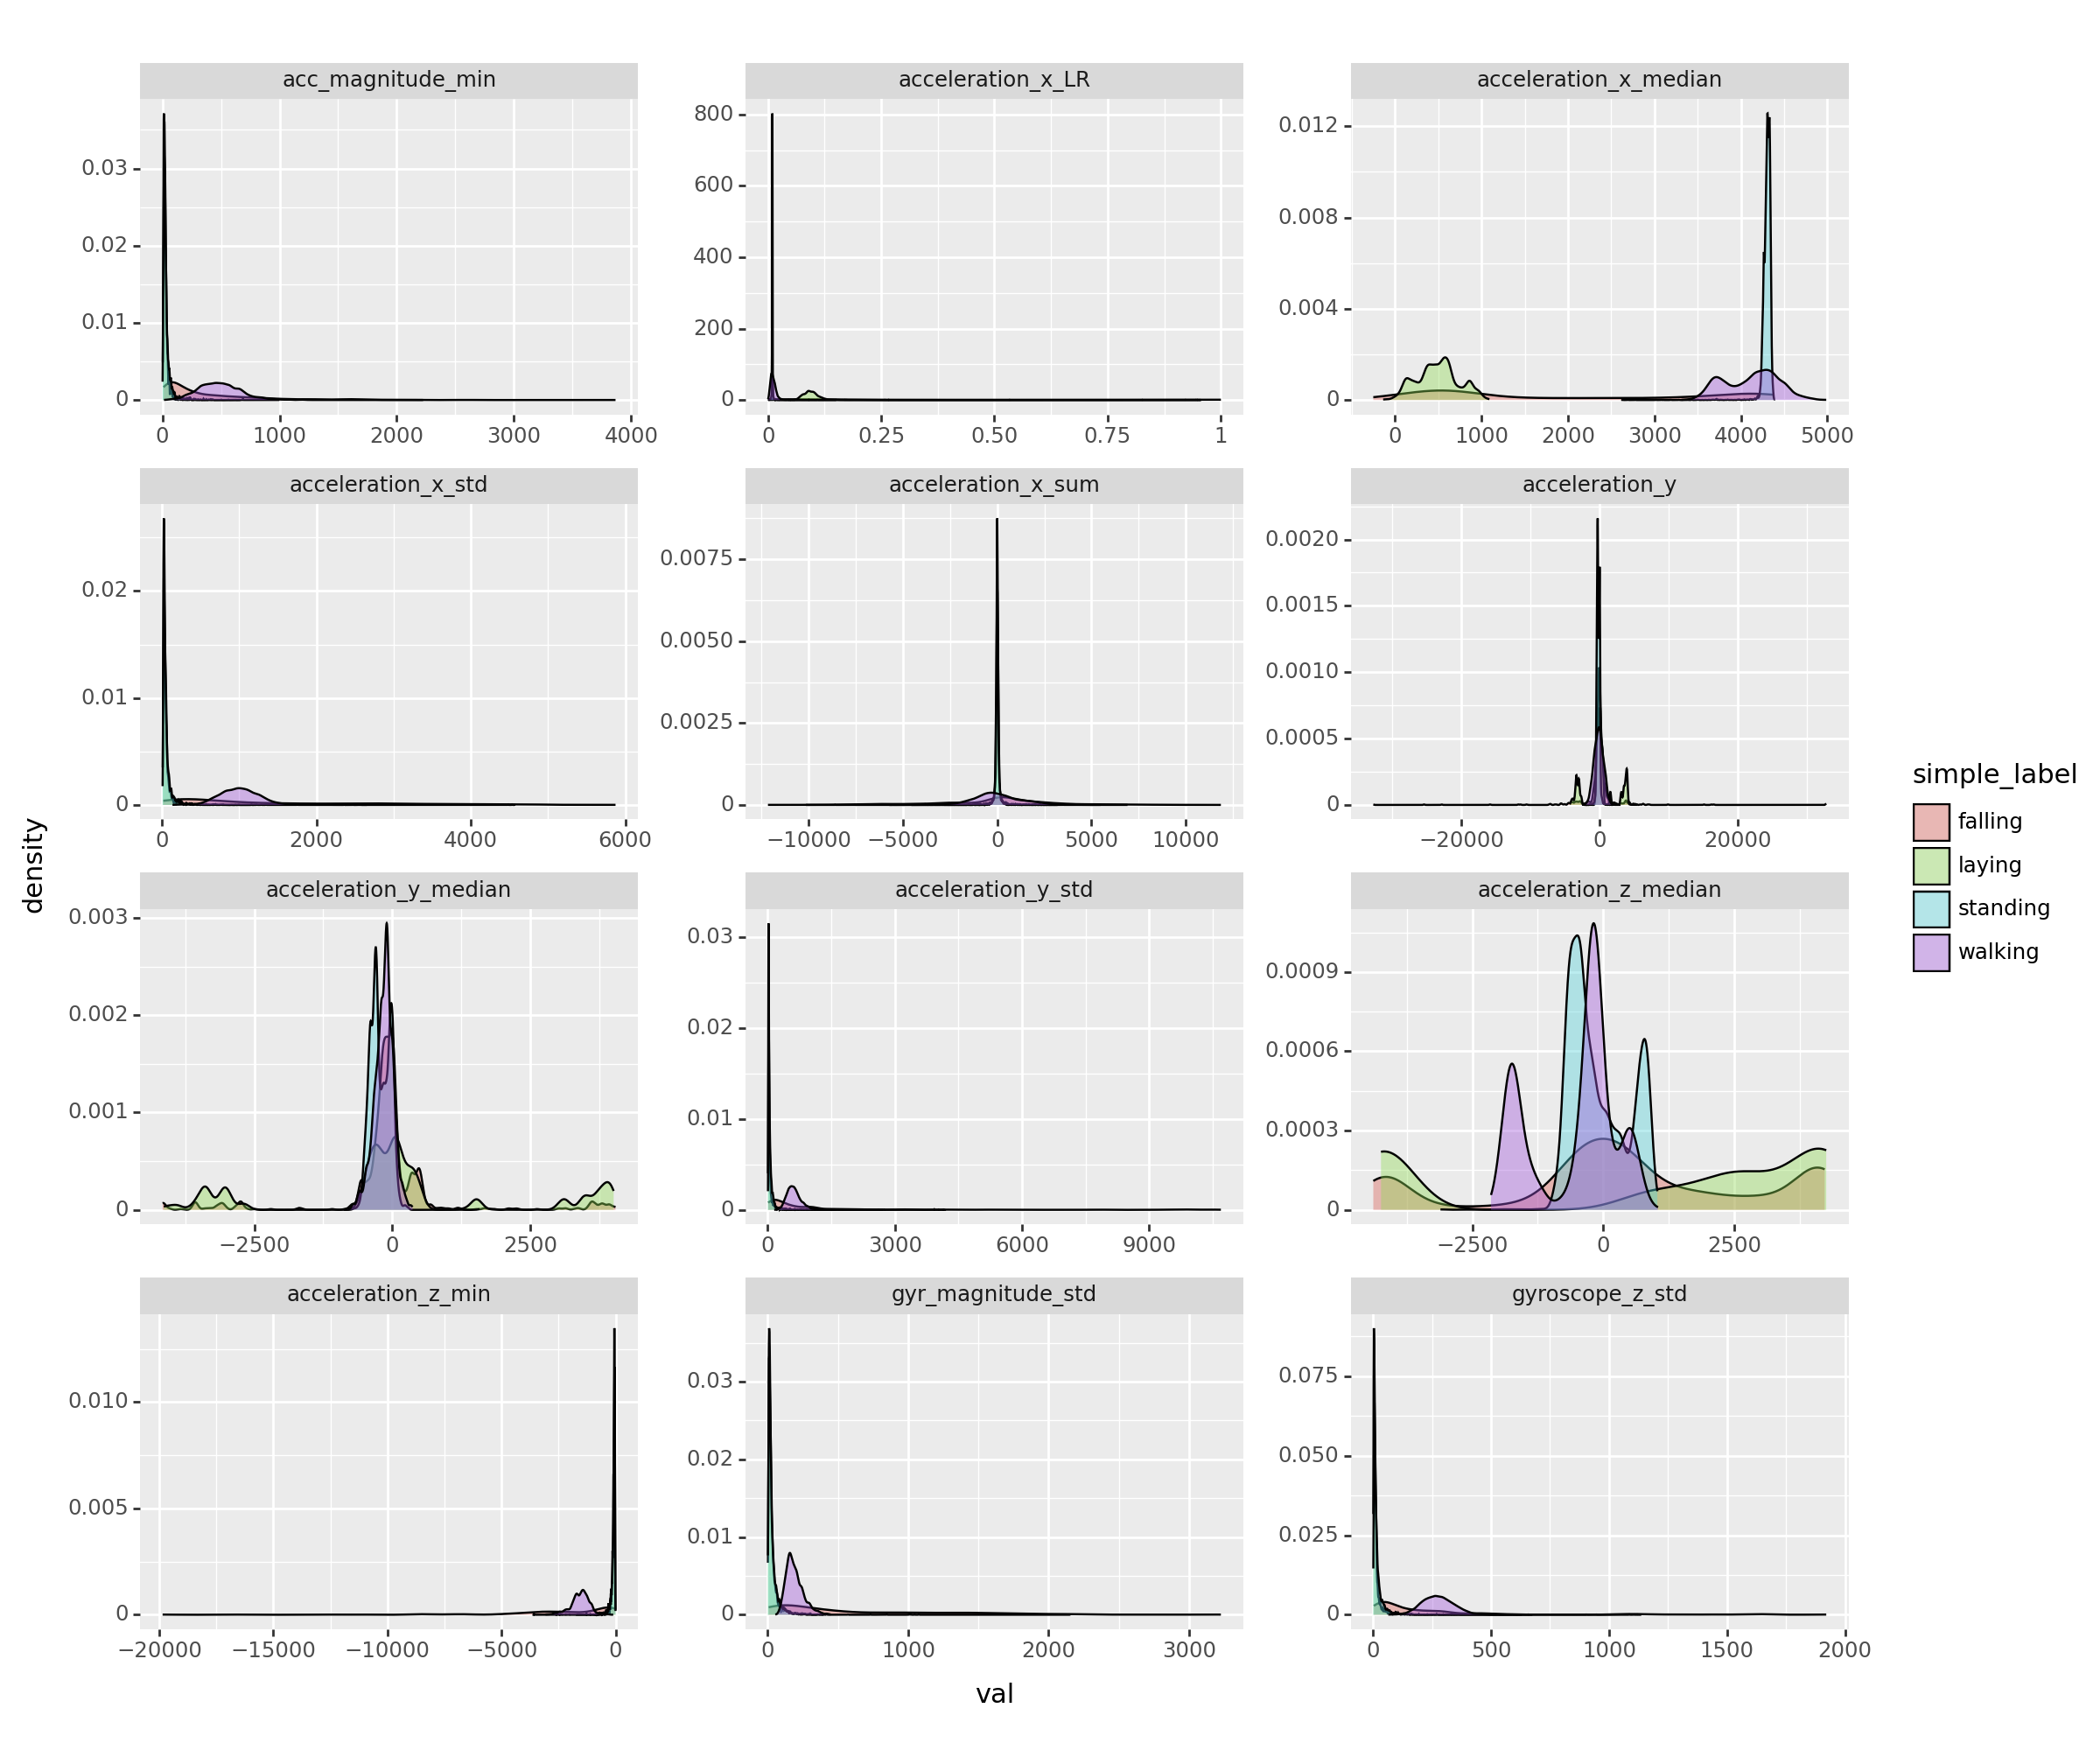

In [55]:
# for fn in selected_feature:
#     x_temp_feat_2_ind = x_temp_feat_2.loc[lambda df: df['feat']==fn, :]
#     p = ggplot(x_temp_feat_2_ind, aes(x='val',fill='simple_label'))+geom_density(alpha=0.4)+facet_wrap('feat', scales='free')
#     print(p)

# Adjust x-limit for each graph to be the 90th percentile
p = ggplot(x_temp_feat_2[x_temp_feat_2['feat'].isin(X_selected.columns)], aes(x='val', fill='simple_label')) + geom_density(alpha=0.4, trim=True) + facet_wrap('feat', scales='free', ncol=3) + theme(figure_size=(12, 10))
print(p)

In [ ]:
cols=["acceleration_x_median","acceleration_y_median","acceleration_z_median"]

for fn in x_temp['filename'].unique():
    x_temp_ind = x_temp.loc[lambda df: df['filename']==fn, :]
    t = np.arange(len(x_temp_ind))/20
    plt.plot(t,x_temp_ind[cols[0]],label=cols[0])
    plt.plot(t,x_temp_ind[cols[1]],label=cols[1])
    plt.plot(t,x_temp_ind[cols[2]],label=cols[2])
    plt.title(fn)
    plt.legend()
    plt.show()

In [ ]:
# Plot distribution of points by Students 
dataset_feat.groupby('simple_label')['acc_magnitude_std'].plot(kind='hist', alpha=0.5, density=True)

# Add legend to plot
plt.legend(dataset_feat['label'].unique(), title='acc_magnitude_mean')

# Add x-axis label
plt.xlabel('Marks') 
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Group data by 'simple_label'
grouped_data = dataset_feat.groupby('simple_label')

# Plot scatter plot for each group
for label, group in grouped_data:
    plt.scatter(group['acc_magnitude_mean'], group['gyr_magnitude_mean'], label=label, alpha=0.3)
    # plt.scatter(group['acc_magnitude_std'], group['gyr_magnitude_std'], label=label, alpha=0.3)
    # plt.scatter(group['acc_magnitude_sum'], group['gyr_magnitude_sum'], label=label, alpha=0.3)
    # plt.scatter(group['acc_magnitude_mean'], group['acc_magnitude_std'], label=label, alpha=0.3)

# Add legend to plot
plt.legend(title='Simple Label')

# Add labels
plt.xlabel('Mean of acc_magnitude')
plt.ylabel('Standard Deviation of acc_magnitude')

# Show plot
plt.show()
